<img style="float: left;" src="earth-lab-logo-rgb.png" width="150" height="150" />

# Earth Analytics Education - EA  Python Course Spring 2021

## Important  - Assignment Guidelines

1. Before you submit your assignment to GitHub, make sure to run the entire notebook with a fresh kernel. To do this first, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart & Run All)
2. Always replace the `raise NotImplementedError()` code with your code that addresses the activity challenge. If you don't replace that code, your notebook will not run.

```
# YOUR CODE HERE
raise NotImplementedError()
```

3. Any open ended questions will have a "YOUR ANSWER HERE" within a markdown cell. Replace that text with your answer also formatted using Markdown.
4. **DO NOT RENAME THIS NOTEBOOK File!** If the file name changes, the autograder will not grade your assignment properly.
6. When you create a figure, comment out `plt.show()` to ensure the autograder can grade your plots. For figure cells, DO NOT DELETE the code that says `DO NOT REMOVE LINE BELOW`.

```
### DO NOT REMOVE LINE BELOW ###
student_plot1_ax = nb.convert_axes(plt)
```

* Only include the package imports, code, and outputs that are required to run your homework assignment.
* Be sure that your code can be run on any operating system. This means that:
   1. the data should be downloaded in the notebook to ensure it's reproducible
   2. all paths should be created dynamically using the `os.path.join`

## Follow to PEP 8 Syntax Guidelines & Documentation

* Run the `autopep8` tool on all cells prior to submitting (HINT: hit shift + the tool to run it on all cells at once!
* Use clear and expressive names for variables. 
* Organize your code to support readability.
* Check for code line length
* Use comments and white space sparingly where it is needed
* Make sure all python imports are at the top of your notebook and follow PEP 8 order conventions
* Spell check your Notebook before submitting it.

For all of the plots below, be sure to do the following:

* Make sure each plot has a clear TITLE and, where appropriate, label the x and y axes. Be sure to include UNITS in your labels.


### Add Your Name Below 
**Your Name: Jacquelyn Witte**

<img style="float: left;" src="colored-bar.png"/>

---

# Week 04 and 05 Homework - Automate NDVI Workflow

For this assignment, you will write code to generate a plot of the mean normalized difference vegetation index (NDVI) for two different sites in the United States across one year of data:

* San Joaquin Experimental Range (SJER) in Southern California, United States
* Harvard Forest (HARV) in the Northeastern United States

The data that you will use for this week is available from **earthpy** using the following download: 

`et.data.get_data('ndvi-automation')`

## Assignment Goals

Your goal in this assignment is to create the most efficient and concise workflow that you can that allows for:

1. The code to scale if you added new sites or more time periods to the analysis.
2. Someone else to understand your workflow.
3. The LEAST and most efficient (i.e. runs fast, minimize repetition) amount of code that completes the task.

### HINTS

* Remove values outside of the landsat valid range of values as specified in the metadata, as needed.
* Keep any output files SEPARATE FROM input files. Outputs should be created in an outputs directory that is created in the code (if needed) and/or tested for.
* Use the functions that we demonstrated during class to make your workflow more efficient.
* BONUS - if you  chose - you can export your data as a csv file. You will get bonus points for doing this.


## Assignment Requirements

Your submission to the GitHub repository should include:
* This Jupyter Notebook file (.ipynb) with:
    * The code to create a plot of mean NDVI across a year for  2 NEON Field Sites:
        * NDVI on the x axis and formatted dates on the y for both NEON sites on one figure/axis object
    * The **data should be cleaned to remove the influence of clouds**. See the [earthdatascience website for an example of what your plot might look like with and without removal of clouds](https://www.earthdatascience.org/courses/earth-analytics-python/create-efficient-data-workflows/).
* BONUS: Create one output `.csv` file that has 3 columns - NDVI, Date and Site Name - with values for SJER and HARV.

Your notebook should:
* Have *at least* 2 well documented and well named functions with docstrings.
* Include a Markdown cell at the top of the notebook that outlines the overall workflow using pseudocode (i.e. plain language, not code)
* Include additional Markdown cells throughout the notebook to describe: 
    * the data that you used - and where it is from
    * how data are being processing
    * how the code is optimized to run fast and be more concise

# Replace this cell with your pseudocode  for this workflow

If you happen to be a diagram person a diagram is ok too



# Pseudocode for this workflow

### There are three required files to get a single mean NDVI value:
    1. Landsat tif
    2. Landsat QC tif
    3. Landsat shapefile

### The basic flow to calculate the mean NDVI for a single date of measurements:
- Read the image tifs
- Read the QA tif
- Read the shapefile
- Merge the individual tif bands into a single xarray
- Crop the dataArray using the shapefile
- Clean the cropped dataArray - remove 0's and high values
- Mask the dataArray using the QA tif
- Calculate the NDVI
- Calculate the mean NDVI
- Turn it into a dataFrame
- Plot it

The idea is to create many functions to perform most of the outlined steps above. When looping through all the data directories to calculate a single mean NDVI value and grab it's metadata, the sequence of code will be a series of function calls only.

Note, that I am choosing to read all the bands so there is the option to look at RGB or CIR in the future. 

### Function 1 - Retrieve tif files

    bands_tif = sorted(os.path.join(landsat_path,'*band[2-5]*.tif'))
    qa_tif = os.path.join(landsat_path,'*qa*.tif')

### Function 2 - Key metadata: date and site

    site = filepath.split('/')[2]
    date = datetime.strptime(filepath.split('T')[0][-10:-2], "%Y%m%d")

### Function 3 - Consolidated Landsat image, cropped and cloud-free

    # For loop over tif files and append to a list.
    all_bands = []
    for i, aband in enumerate(files):
        all_bands.append(rxr.open_rasterio(aband, masked=True).squeeze())
        # Assign a band number to the new xarray object
        all_bands[i]["band"] = i+1
        
    # Turn list of bands into a single xarray object
    - Create xarray.DataArray with xr.concat()
    
    # Crop the data to the shapefile
    - Use dataArray.rio.clip(crop_boundary.geometry) method
    
    # IMPORTANT: Clean the dataArray - remove 0's and high values
    # I went with a less elegant but explicit and clear code that I can understand. 
    data_nozeros_xr = data_xr_crop.where(data_xr_crop > 0, np.nan)
    data_nozeros_xr = data_nozeros_xr.where(data_nozeros_xr < 10000, np.nan)

### Function 4 - Apply cloud mask

Reference: https://github.com/earthlab-education/ea-python-course-notebooks/
                       blob/main/2022/completed-demos/05-l1-landsat-cloud-masks.ipynb

    # Read the QA file
    qa_xr = rxr.open_rasterio(qa_file).squeeze()
    
    # Create cloud mask using earthpy mask package for Landsat imagery
    high_cloud_confidence = (
        em.pixel_flags["pixel_qa"]["L8"]["High Cloud Confidence"])
    cloud = em.pixel_flags["pixel_qa"]["L8"]["Cloud"]
    cloud_shadow = em.pixel_flags["pixel_qa"]["L8"]["Cloud Shadow"]
    
    # Add up all the mask values
    all_masked_values = cloud_shadow + cloud + high_cloud_confidence
    
    # Apply the masking to the data xarray
    data_cld_free_xr = data_xr.where(~qa_xr.isin(all_masked_values))

### Function 5 - Calculate NDVI and take the mean

    ndvi_xr = es.normalized_diff(data_xr[3], data_xr[2])
    # IMPORTANT: Replace dataArray NAN with numpy NAN. 
    # Otherwise there are warnings when creating a dataFrame

## -------------------------------------------------------------------------- 
## Main code to process mean NDVI time series from multiple sites


### Get the site name from the base folders
    base_path = os.path.join('ndvi-automation',
                         'sites')
    sitenames = os.listdir(base_path)

### Initialize the desired variables that will define the dataFrame
    date = []
    site = []
    mean_ndvi = []

### Parent loop - over the sites
    for s in sitenames:
        # Read the shapefile from the base_path
        shapefile = glob(os.path.join(base_path, s, 'vector', '*shp'))[0]
        landsat_buffer_shp = gpd.read_file(shapefile)
        
    # Loop through all the Landsat directories per site
    for fdir in sorted(glob(os.path.join(base_path, s, 'landsat-crop', '*'))):

        # Get the Bands and QA files per data directory
        Call Function 1

        # Get the site name and date
        Call Function 2
        Append to date and site

        # Read the Landsat data - bands into a single dataArray, cropped to the shapefile
        Call Function 3

        # Apply cloud mask
        Call Function 4

        # Calculate the mean ndvi
        Call Function 5
        Append to mean_ndvi

### Create a pandas dataFrame via a dictionary
    dict = {'Date': date,
        'site': site,
        'mean_ndvi': mean_ndvi}
    ndvi_df = pd.DataFrame(dict).set_index('Date')

## ------------- Create the Figure ---------------------- 
 
#### Reference to ignore NaN: https://www.bmc.com/blogs/pandas-nan-missing-data/

    fig, ax = plt.subplots(figsize=(12, 6))

    for s, df in ndvi_df.dropna().groupby('site'):
        ax.plot(df['mean_ndvi'],
            'o-',
            label=s)

    title = 'Mean NDVI from Landsat 8 (Cloud-free)\nMeasurements taken in 2017'
    ax.set(title=title,
           xlabel='Month',
           ylabel='NDVI')
    ax.legend()


In [1]:
# Autograding imports - do not modify this cell
import matplotcheck.autograde as ag
import matplotcheck.notebook as nb
import matplotcheck.timeseries as ts
from datetime import datetime

In [2]:
# Import needed packages in PEP 8 order
# and no unused imports listed (10 points total)

import os
from glob import glob

import earthpy as et
import earthpy.mask as em
import earthpy.plot as ep
import earthpy.spatial as es
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
import pandas as pd
import rioxarray as rxr
import seaborn as sns
import xarray as xr

# Prettier plotting with seaborn
sns.set(font_scale=1.3, style="whitegrid")

In [3]:
# Download data
et.data.get_data('ndvi-automation')

'/Users/jwitte/earth-analytics/data/ndvi-automation/.'

In [4]:
# Change to data directory
data_dir = os.path.join(et.io.HOME,
                        'earth-analytics',
                        'data')
os.chdir(data_dir)

In [5]:
# DO NOT MODIFY THIS CELL
# Tests that the working directory is set to earth-analytics/data

path = os.path.normpath(os.getcwd())
student_wd_parts = path.split(os.sep)

if student_wd_parts[-2:] == ['earth-analytics', 'data']:
    print("\u2705 Great - it looks like your working directory is set correctly to ~/earth-analytics/data")
else:
    print("\u274C Oops, the autograder will not run unless your working directory is set to earth-analytics/data")

✅ Great - it looks like your working directory is set correctly to ~/earth-analytics/data


# Figure 1: Plot 1 - Mean NDVI For Each Site Across the Year (50 points)

Create a plot of the mean normalized difference vegetation index (NDVI) for the two different sites in the United States across the year: 

* NDVI on the x axis and formatted dates on the y for both NEON sites on one figure/axis object.
* Each site should be identified with a different color in the plot and legend.
* The final plot **data should be cleaned to remove the influence of clouds**.
* Be sure to include appropriate title and axes labels.

Add additional cells as needed for processing data (e.g. defining functions, etc), but be sure to:
* follow the instructions in the code cells that have been provided to ensure that you are able to use the sanity check tests that are provided. 
* include only the plot code in the cell identified for the final plot code below

## Task 1: 

In the cell below, create a single dataframe containing MEAN NDVI, the site name, 
and the date of the data for the HARV site 
scene `HARV/landsat-crop/LC080130302017031701T1-SC20181023151837`.  The column names for the  final
DataFrame should be`mean_ndvi`, and `site`, and the data should be **indexed on the date**. 

Use the functions that we reviewed in class (or create your own versions of them) to implement your code

### In the Cell below Place  All Functions Needed to Run this Notebook (20 points)

In [6]:
### DO NOT REMOVE THIS LINE OR EDIT / MOVE THIS CELL ###
start_time = datetime.now()

### Function 1 - Retrieve tif files

In [7]:
def find_tifs(landsat_path):
    """Finds all Landsat tif files in a single directory

    Extracts the bands and the quality flag tifs separately

    Parameters
    ----------
    landsat_path : String
        Path to the directory of tif files

    Returns
    -------
    bands_files : String
        List of bands tif files
        
    qa_file : String
        Quality flag file
    """
    bands_tif = os.path.join(landsat_path,
                             '*band[2-5]*.tif')
    qa_tif = os.path.join(landsat_path,
                          '*qa*.tif')

    bands_files = sorted(glob(bands_tif))
    qa_file = glob(qa_tif)[0]

    return bands_files, qa_file

### Function 2 - Retrieve key metadata: date and site

In [8]:
def get_site_date(filepath):
    """Gets the date and site name from the file path

    Parameters
    ----------
    filepath : String

    Returns
    -------
    site : String
    date : String
    """
    site = filepath.split('/')[2]
    date = datetime.strptime(filepath.split('T')[0][-10:-2], "%Y%m%d")

    return site, date

### Function 3 - Return consolidate Landsat bands that are cropped and cloud-free 

In [9]:
def landsat_read_rgbbands(files, crop_boundary):
    """Consolidates Landsat RGB+NIR bands into a single dataArray

    Takes a list of Landsat RGB+NIR bands for a single date and returns
    a single dataArray of consolidated bands 2-5

    Band 2 = Blue -> Index 0
    Band 3 = Green -> Index 1
    Band 4 = Red -> Index 2
    Band 5 = NIR -> Index 3

    Parameters
    ----------
    files: List
        A list of Landsat tif images
    crop_boundary : shapefile dataArray

    Returns
    -------
    data_xr : dataArray
        Consolidated all bands in files cropped to shapefile

    """
    all_bands = []
    for i, aband in enumerate(files):
        all_bands.append(
            (rxr.open_rasterio(aband, masked=True)
             # Inlcuding from_disk=True makes code run faster
             .rio.clip(crop_boundary.geometry, from_disk=True)
             .squeeze())
        )
        # Assign a band number to the new xarray object
        all_bands[i]["band"] = i+1

    # Turn list of bands into a single xarray object
    data_xr_crop = xr.concat(all_bands, dim="band")

    # IMPORTANT: Clean the dataArray - remove 0's and high values
    data_nozeros_xr = data_xr_crop.where(data_xr_crop > 0, np.nan)
    data_nozeros_xr = data_nozeros_xr.where(data_nozeros_xr < 10000, np.nan)

    return data_nozeros_xr

### Function 4 - Apply cloud mask

In [10]:
def apply_cloud_mask(data_xr, qa_file, crop_boundary):
    """Applies a cloud mask to Landsat dataArray

    Parameters
    ----------
    qa_file : String
        Path to the Landsat quality flag file

    data_xr : dataArray
        Landsat 8 band consolidated dataArray

    crop_boundary : shapefile dataArray

    Returns
    -------
    Cloud free and cropped dataArray

    """
    # Read the quality flags file
    qa_xr = (rxr.open_rasterio(qa_file, masked=True)
             .rio.clip(crop_boundary.geometry, from_disk=True)
             .squeeze())

    # Create cloud mask using earthpy mask package for Landsat imagery
    high_cloud_confidence = (
        em.pixel_flags["pixel_qa"]["L8"]["High Cloud Confidence"])
    cloud = em.pixel_flags["pixel_qa"]["L8"]["Cloud"]
    cloud_shadow = em.pixel_flags["pixel_qa"]["L8"]["Cloud Shadow"]

    # Add up all the mask values
    all_masked_values = cloud_shadow + cloud + high_cloud_confidence

    # Apply the masking to the data xarray
    data_cld_free_xr = data_xr.where(~qa_xr.isin(all_masked_values))

    return data_cld_free_xr

### Function 5 - Calculate NDVI and return the mean

In [11]:
def calc_mean_ndvi(data_xr):
    """Calculates the NDVI and returns the mean

    Reference: https://stackoverflow.com/questions/49867345/
    how-to-deal-with-inf-values-when-computting-the-average-of-values-of-a-list-in-p

    Parameters
    ----------
    data_xr : dataArray
        The Landsat data

    Returns
    -------
    float : numpy
        The mean NDVI
    """
    ndvi_xr = es.normalized_diff(data_xr[3], data_xr[2])

    # Calculating my own NDVI
    # ndvi_xr = (data_xr[3] - data_xr[2]) / (data_xr[3] + data_xr[2])
    # ndvi_clean = ndvi_xr.where(np.isfinite(ndvi_xr.values))

    # Replace dataArray NAN with numpy NAN
    ndvi_mean = ndvi_xr.mean()
    if np.isfinite(ndvi_mean):
        result = float(ndvi_mean)
    else:
        result = np.nan

    return result

## Start of the main code - where the magic happens 
### Calculate mean NDVI from Landsat 8 for a single date

- Create dataframe of mean NDVI in this cell using the functions created above
- Important: to use the ungraded tests below as a sanity check, name your columns: mean_ndvi and site
- Call the dataframe at the end of the cell so the tests run on it!
- Be sure that the date column is an index of type date
- HINT: the time series lessons may help you remember how to do this!



In [12]:
base_path = os.path.join('ndvi-automation',
                         'sites')
landsat_path = os.path.join(base_path,
                            'HARV',
                            'landsat-crop',
                            'LC080130302017031701T1-SC20181023151837')
landsat_bufferfile = os.path.join(base_path,
                                  'HARV',
                                  'vector',
                                  'HARV-crop.shp')

# Read shapefile
landsat_buffer_shp = gpd.read_file(landsat_bufferfile)

# Get the Bands and QA files
landsat_bands_files, landsat_qa_file = find_tifs(landsat_path)

# Get the metadata = site name and date
site, date = get_site_date(landsat_path)

# Read the Landsat data - consolidate the bands into a single dataArray
# Crop to the shapefile
landsat_xr = landsat_read_rgbbands(landsat_bands_files,
                                   landsat_buffer_shp)

# Apply cloud mask
landsat_cld_free_xr = apply_cloud_mask(landsat_xr,
                                       landsat_qa_file,
                                       landsat_buffer_shp)

### Plot the cloud-free, cropped dataArray as a check 

<AxesSubplot:title={'center':'Landsat Cloud mask applied'}>

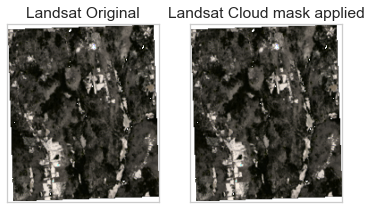

In [13]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(6, 10))
ep.plot_rgb(landsat_xr.values,
            rgb=[2, 1, 0],
            ax=ax1,
            title='Landsat Original')

ep.plot_rgb(landsat_cld_free_xr.values,
            rgb=[2, 1, 0],
            ax=ax2,
            title='Landsat Cloud mask applied')
# Hmmm doesn't look very different. Onward!

### Calculate the NDVI from the cloud-free Landsat image

In [14]:
mean_ndvi = calc_mean_ndvi(landsat_cld_free_xr)

# Create a pandas dataFrame
ndvi_df = pd.DataFrame([[date, site, mean_ndvi]],
                       columns=['Date', 'site', 'mean_ndvi']
                       ).set_index('Date')
ndvi_df

,site,mean_ndvi
Date,,
2017-03-17,HARV,0.281132


In [15]:
# This cell  is testing your data output above

student_ndvi_ts_single_site = _

single_scene_points = 0

# Ensure the data is stored in a dataframe.
if isinstance(student_ndvi_ts_single_site, pd.DataFrame):
    print('\u2705 Your data is stored in a DataFrame!')
    single_scene_points += 1
else:
    print('\u274C It appears your data is not stored in a DataFrame. ',
          'To see what type of object your data is stored in, check its type with type(object)')

# Ensure that the date column is the index
if isinstance(student_ndvi_ts_single_site.index, pd.core.indexes.datetimes.DatetimeIndex):
    print('\u2705 You have the index set to the date column!')
    single_scene_points += 2
else:
    print('\u274C You do not have the index set to the date column.')

# Ensure that the date column is datetime
if isinstance(student_ndvi_ts_single_site.index[0], pd._libs.tslibs.timestamps.Timestamp):
    print('\u2705 The data in your date column is datetime!')
    single_scene_points += 2
else:
    print('\u274C The data in your date column is not datetime.')

# Ensure the site name is correct
if student_ndvi_ts_single_site.site.values[0] == 'HARV':
    print('\u2705 You have the correct site name!')
    single_scene_points += 5
else:
    print('\u274C You do not have the correct site name.')

if np.allclose(0.281131628228094, student_ndvi_ts_single_site.mean_ndvi.values[0]):
    print('\u2705 You have the correct mean NDVI value!')
    single_scene_points += 5
else:
    print('\u274C You do not have the correct mean ndvi value.')

print("\n \u27A1 You received {} out of 15 points for creating a dataframe.".format(
    single_scene_points))
single_scene_points

✅ Your data is stored in a DataFrame!
✅ You have the index set to the date column!
✅ The data in your date column is datetime!
✅ You have the correct site name!
✅ You have the correct mean NDVI value!

 ➡ You received 15 out of 15 points for creating a dataframe.


15

## Task 2:

In the cell below, process all of the landsat scenes. Create a DataFrame that contains the following 
information for each scene


|   | index  | site  | mean_ndvi  | 
|---|---|---|---|
| Date  |   |   |   |
|  2017-01-07  | 0  | SJER  | .4  |  

Be sure to call your dataframe at the end of the cell to ensure autograding works.
HINT: FOR THIS STEP, leave any rows containing missing values (`NAN`).

## Generate mean NDVI  dataFrame for all sites in the `base_path` folder

- Important: to use the ungraded tests below as a sanity check, name your columns: mean_ndvi and site
- Don't forget to set date as the index and make the values of type datetime


In [16]:
# Create dataframe of NDVI including the cleaning data to deal with clouds

# Get the site names
sitenames = os.listdir(base_path)

# Initialize the desired variables
date = []
site = []
mean_ndvi = []

# Loop over the sites
for s in sitenames:
    # Get the shapefile
    shapefile = glob(os.path.join(base_path, s, 'vector', '*shp'))[0]
    print(shapefile)

    # Read shapefile
    landsat_buffer_shp = gpd.read_file(shapefile)

    # Loop through all the Landsat directories per site
    for fdir in sorted(glob(os.path.join(base_path, s, 'landsat-crop', '*'))):

        # Get the Bands and QA files per data directory
        landsat_bands_files, landsat_qa_file = find_tifs(fdir)

        # Get the site name and date
        site_temp, date_temp = get_site_date(fdir)
        site.append(site_temp)
        date.append(date_temp)

        # Read the Landsat data - bands into a single dataArray
        # Cropped to the shapefile
        landsat_xr = landsat_read_rgbbands(landsat_bands_files,
                                           landsat_buffer_shp)

        # Apply cloud mask
        landsat_cld_free_xr = apply_cloud_mask(landsat_xr,
                                               landsat_qa_file,
                                               landsat_buffer_shp)

        # Calculate the mean ndvi
        mean_ndvi.append(calc_mean_ndvi(landsat_cld_free_xr))
    pass
pass

ndvi-automation/sites/SJER/vector/SJER-crop.shp
ndvi-automation/sites/HARV/vector/HARV-crop.shp


### Create the final mean NDVI dataFrame

In [17]:
# Create a pandas dataFrame via a dictionary
dict = {'Date': date,
        'site': site,
        'mean_ndvi': mean_ndvi}
ndvi_df = pd.DataFrame(dict).set_index('Date')
ndvi_df

,site,mean_ndvi
Date,,
2017-01-07,SJER,NaN
2017-01-23,SJER,NaN
2017-02-08,SJER,NaN
2017-02-24,SJER,0.665524
2017-03-12,SJER,0.664109
2017-03-28,SJER,0.702330
2017-04-13,SJER,NaN
2017-04-29,SJER,0.610209
2017-05-15,SJER,0.444823


In [18]:
# Last sanity check before creating your plot (10 points)

# Ensure that you call your dataframe at the bottom of the cell above
# and that it has columns called: mean_ndvi and site

# Ensure the data is stored in a dataframe.
student_ndvi_df = _

df_points = 0

if isinstance(student_ndvi_df, pd.DataFrame):
    print('\u2705 Your data is stored in a DataFrame!')
    df_points +=2
else:
    print('\u274C It appears your data is not stored in a DataFrame. ',
          'To see what type of object your data is stored in, check its type with type(object)')

# Check that dataframe contains the appropriate number of NAN values
if student_ndvi_df.mean_ndvi.isna().sum() == 15:
    print('\u2705 Correct number of masked data values!')
    df_points +=2
else:
    print('\u274C The amount of null data in your dataframe is incorrect.')


# Ensure that the date column is the index
if isinstance(student_ndvi_df.index, pd.core.indexes.datetimes.DatetimeIndex):
    print('\u2705 You have the index set to the date column!')
    df_points +=3
else:
    print('\u274C You do not have the index set to the date column.')

# Ensure that the date column is datetime
if isinstance(student_ndvi_df.index[0], pd._libs.tslibs.timestamps.Timestamp):
    print('\u2705 The data in your date column is datetime!')
    df_points +=3
else:
    print('\u274C The data in your date column is not datetime.')

# Output for timer, # DO NOT MODIFY
end_time = datetime.now()
total_time = end_time - start_time
print(
    "Your total run time for processing the data was {0}.".format(total_time))

print("\n \u27A1 You received {} out of 10 points for creating a dataframe.".format(
    df_points))

df_points

✅ Your data is stored in a DataFrame!
✅ Correct number of masked data values!
✅ You have the index set to the date column!
✅ The data in your date column is datetime!
Your total run time for processing the data was 0:00:10.022262.

 ➡ You received 10 out of 10 points for creating a dataframe.


10

## Figure of mean NDVI over the 2 NEON field sites

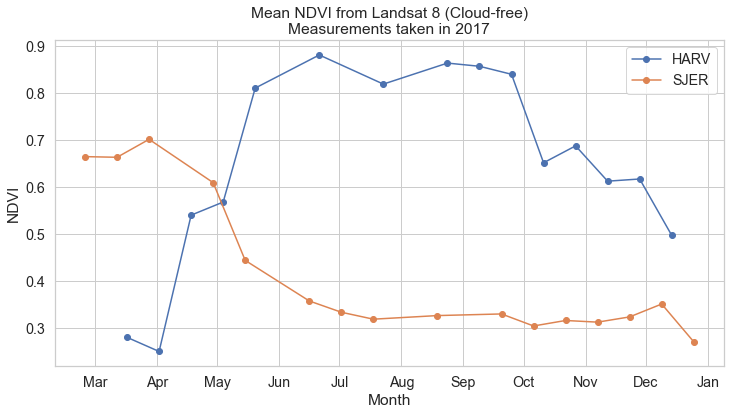

In [19]:
# Add only the plot code to this cell
# Ref: https://www.bmc.com/blogs/pandas-nan-missing-data/

fig, ax = plt.subplots(figsize=(12, 6))

for s, df in ndvi_df.dropna().groupby('site'):
    ax.plot(df['mean_ndvi'],
            'o-',
            label=s)

# Define the date format
date_fmt = DateFormatter("%b")
ax.xaxis.set_major_formatter(date_fmt)

# Add labels
title = 'Mean NDVI from Landsat 8 (Cloud-free)\nMeasurements taken in 2017'
ax.set(title=title,
       xlabel='Month',
       ylabel='NDVI')
ax.legend()

### DO NOT REMOVE LINES BELOW ###
final_masked_solution = nb.convert_axes(plt, which_axes="current")

In [20]:
# Ignore this cell for the autograding tests


In [21]:
# Ignore this cell for the autograding tests


# Question 1 (10 points)

Imagine that you are planning NEON’s upcoming flight season to capture remote sensing data in these locations and want to ensure that you fly the area when the vegetation is the most green.

When would you recommend the flights take place for each site? 

Answer the question in 2-3 sentences in the Markdown cell below.

NDVI measures the <i>greenness</i> of a terrain where high values (near 1.0) indicate a dense vegetation, i.e. rainforest, and near zero values correspond to the absense of vegetation (Reference: https://earthobservatory.nasa.gov/features/MeasuringVegetation#:~:text=The%20most%20common%20measurement%20is,rainforests%20(0.6%20to%200.8).). Based on the plot above, to capture high vegetation seasons I would fly mid-May through September for HARV domain (essentially the summer months) and March through April over SJER (early spring months).

# Question 2 (10 points)

How could you modify your workflow to look at vegetation changes over time in each site? 

Answer the question in 2-3 sentences in the Markdown cell below.

Well, for one I would use a longer time series because then I can subtract the monthly mean from a monthly climatology, i.e. May 2017 minus (all the Mays for 10 years). I would also add other observations such as soil moisture, temperature, fires, and precipitation that impact vegetation. There may be strong correlations that can explain observed monthly variations in NDVI. Finally, for the dataset given, I can examine CIR imagery which is good for (1) identifying plant species, (2) estimating biomass of vegetation, (3) assessing soil moisture. Reference: https://www.mngeo.state.mn.us/chouse/airphoto/cir.html

# Do not edit this cell! (10 points)

The notebook includes:
* additional Markdown cells throughout the notebook to describe: 
    * the data that you used - and where it is from
    * how data are being processing
    * how the code is optimized to run fast and be more concise

# Do not edit this cell! (20 points)

The notebook will also be checked for overall clean code requirements as specified at the **top** of this notebook. Some of these requirements include (review the top cells for more specifics): 

* Notebook begins at cell [1] and runs on any machine in its entirety.
* PEP 8 format is applied throughout (including lengths of comment and code lines).
* No additional code or imports in the notebook that is not needed for the workflow.
* Notebook is fully reproducible. This means:
   * reproducible paths using the os module.
   * data downloaded using code in the notebook.
   * all imports at top of notebook.

## Complete Bonus - Export to a CSV file

#### Initially, I exported to the outputs/ folder in the ndvi-automation/ data folder but this file has to also be saved to my assignment folder so I can upload to the github repo.

In [22]:
# This path is specific to my assignment repo so I can add it to gitHub
# output_path = os.path.join(et.io.HOME,
#                            'earth-analytics',
#                            'ea-2022-04-ndvi-automation-jacquiewitte')

# This path is reproducible
output_path = os.path.join('ndvi-automation',
                           'outputs')

# Converting to CSV file
ndvi_df.to_csv(output_path+'/Landsat8_ndvi_neon2017.csv')

## BONUS - Export a  .CSV File to Share (10 points possible)

This is optional - if you export a **.csv** file with the columns specified above: Site, Date and NDVI Value you can get an additional 10 points.

* FULL CREDIT: File exists in csv format and contains the columns specified.
We will check your github repo for this file!
